In this part of the project you will simulate an image recommender system.

In [2]:
import pandas as pd
import numpy as np
import random
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from CSE6240_utilities import plot_confusion_matrix
import matplotlib.pylab as pylab

from scipy.stats import pearsonr

### Simulate User-Image Matrix

In [3]:
def category_selector():
# this function is used to randomly sample four out of the six movie categories 

    categories=[0,1,2,3,4,5]
    return sorted(random.sample(categories,4))

In [4]:
user_ratings = np.zeros((1000,6000))
# construct a matrix to store users' rating for movies.
# We assume there are 1000 users and 6000 movies(1000 in each category),
# and each row in this matrix stands for one user

In [5]:
for i in range(1000):
    num_reviews=np.random.geometric(p = 0.1,size = 4)
    # generate four values from the Geo(0.1) distribution, each stands for the number of ratings of a user under a category

    categories = category_selector()
    # use this function to choose which four categories this user has rated

    for j in range(4):
        candidates=random.sample(range(categories[j] * 1000, categories[j] * 1000 + 1000), num_reviews[j])
        mu=random.random() * 3 + 1.5
        for k in candidates:
            user_ratings[i][k] = stats.truncnorm.rvs((1 - mu) / 1, (5 - mu) / 1, loc = mu, scale = 1)
            # generate ratings which follows a truncated normal distribution

### Singular Value Decomposition

In [7]:
U, Sigma, VT = np.linalg.svd(user_ratings.transpose())

Singular values:


,i,sigma_i,sigma_i^2,err_i^2,err_i,relerr_i
0,0,59.455782,3534.990071,391662.909594,625.829777,0.913239
1,1,41.348355,1709.686466,389953.223128,624.462347,0.911244
2,2,40.887210,1671.763968,388281.459160,623.122347,0.909289
3,3,39.549806,1564.187165,386717.271995,621.865960,0.907455
4,4,38.265855,1464.275696,385252.996299,620.687519,0.905736


...


,i,sigma_i,sigma_i^2,err_i^2,err_i,relerr_i
995,995,7.379128,54.451526,184.673463,13.589461,0.019830
996,996,7.354047,54.082011,130.591452,11.427662,0.016676
997,997,6.917833,47.856409,82.735043,9.095881,0.013273
998,998,6.747101,45.523369,37.211674,6.100137,0.008902
999,999,6.100137,37.211674,0.000000,0.000000,0.000000


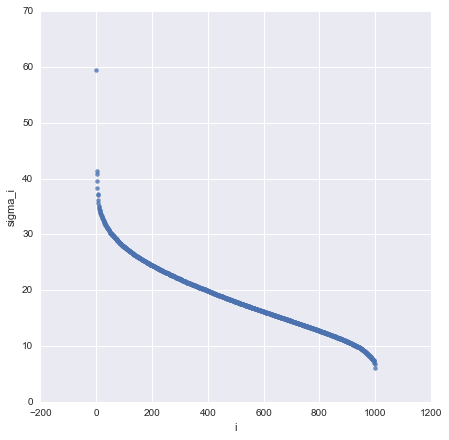

In [7]:
def peek_Sigma (Sigma, ret_df=False):
    k = len (Sigma)
    df_Sigma = pd.DataFrame (np.arange (len (Sigma)), columns=['i'])
    df_Sigma['sigma_i'] = Sigma
    Sigma_sq = np.power (Sigma, 2)
    Err_sq = np.sum (Sigma_sq) - np.cumsum (Sigma_sq)
    Err_sq[Err_sq < 0] = 0
    Err = np.sqrt (Err_sq)
    Relerr = Err / (Sigma[0] + Err[0])
    df_Sigma['sigma_i^2'] = Sigma_sq
    df_Sigma['err_i^2'] = Err_sq
    df_Sigma['err_i'] = Err
    df_Sigma['relerr_i'] = Relerr
    print "Singular values:"
    display (df_Sigma.head (5))
    print "..."
    display (df_Sigma.tail (5))

    f, ax = plt.subplots (figsize=(7, 7))
    #ax.set (yscale="log")
    sns.regplot ("i", "sigma_i", df_Sigma, ax = ax, fit_reg = False)
    if ret_df:
        return df_Sigma

peek_Sigma(Sigma)

### Reconstruct data points on new bases

In [8]:
k = 1000
X = U[:, 0:k].dot(np.diag(Sigma[0:k]))
y = pd.read_csv("label.csv", header = None).values.reshape(-1)

### KNN using Euclidean Distance and Confusion Matrix

In [9]:
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
clf.fit(X, y)

y_pred = clf.predict(X)

In [10]:
cm = confusion_matrix(y, y_pred)
print(cm)

[[837  37  15  25  55  31]
 [115 794   8  14  34  35]
 [194  95 546  20  66  79]
 [172 109  28 532  94  65]
 [ 70  53  20  14 825  18]
 [ 37  71  30  25  57 780]]


Recom | euclidean
accuracy = 0.7190


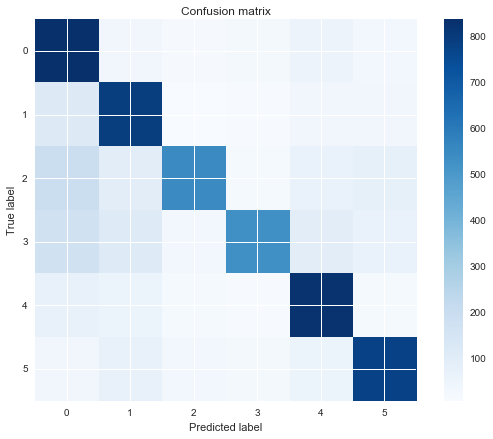

In [11]:
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session

print "Recom | euclidean"
plot_confusion_matrix(cm)
print "accuracy = %.4f" % (1.0 * np.sum(np.diag(cm)) / np.sum(np.sum(cm, axis = 0)))

### KNN using Pearson Coef and Confusion Matrix

this is super slow and seems not able to get result for all models

In [ ]:
def pearson(x, y):
     return 1.0 - pearsonr(x, y)[0]

clf = KNeighborsClassifier(n_neighbors = 5, metric = pearson)
clf.fit(X, y)

y_pred = clf.predict(X)

In [ ]:
cm = confusion_matrix(y, y_pred)
print(cm)

print "Recom | pearson"
plot_confusion_matrix(cm)

### Conclusion